In [427]:
import numpy as np
from scipy.interpolate import interp2d
import pyradi.ryplot as ryplot
import pandas as pd
%matplotlib inline

np.set_printoptions(linewidth=120)

bedRadius = 110. 
towerRadius = 180.
towerClearance = 75.
probeRadius = 104.
numpoints = 10
xoffset = -33.5
yoffset = -5. 
maxsize = 1.4 *  bedRadius 
numg30=5

In [428]:
x = np.linspace(-maxsize,maxsize,numpoints)
x = np.sort(np.append(x, np.asarray([ -72.5, 72.5, 0. ])-xoffset))
y = np.linspace(-maxsize,maxsize,numpoints) 
y = np.sort(np.append(y, np.asarray([ -44, 0.,95.00  ])-yoffset))

xx,yy = np.meshgrid(x,y)
radius = np.sqrt(xx*xx+yy*yy)

xp = xx + xoffset
yp = yy + yoffset
prbRadius = np.sqrt(xp*xp+yp*yp)


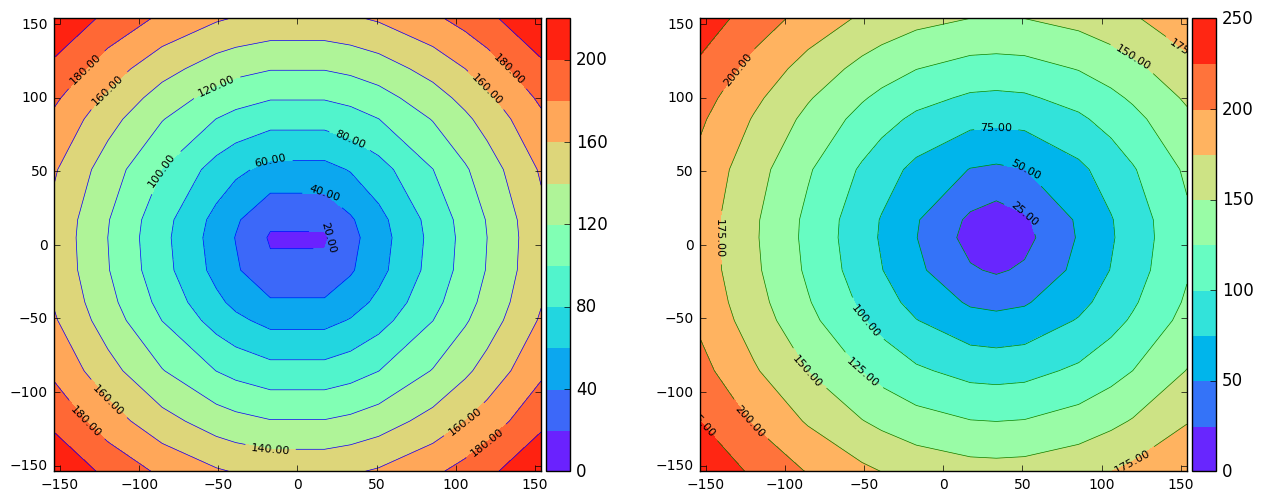

In [429]:
p = ryplot.Plotter(1,1,2,figsize=(15,6))
p.meshContour(1,xx,yy,radius,contLabel=True,cbarshow=True)
p.meshContour(2,xx,yy,prbRadius,contLabel=True,cbarshow=True)


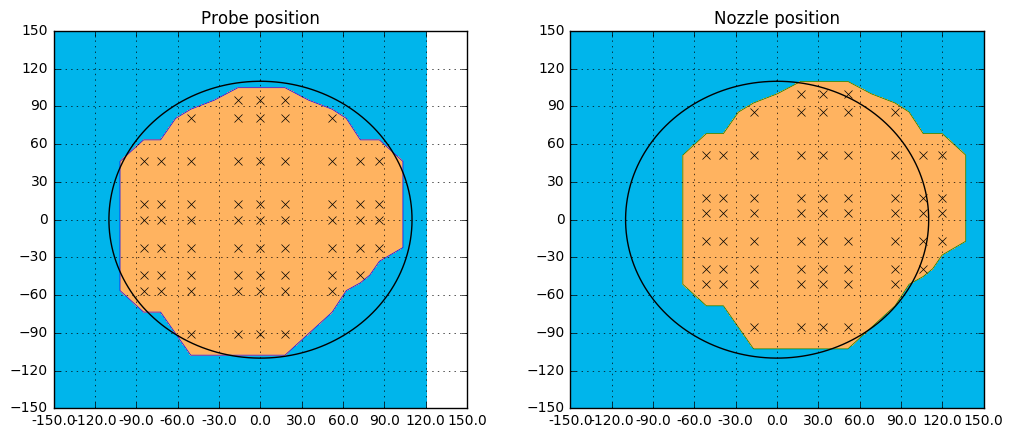

In [438]:
valid = np.ones((xx.shape))
valid =  np.logical_and(valid, -0.5 * xx - yy  <  towerRadius-towerClearance    ) # x tower
# valid =  np.logical_and(valid,  0.5 * xx - yy  <  towerRadius-towerClearance-4.) # y tower
valid =  np.logical_and(valid,             yy  <  towerRadius-towerClearance    )  # z tower
# valid =  np.logical_and(valid,             xx  <  bedRadius +50    )  # y tower
valid =  np.logical_and(valid,   yy  > 2 * xx - (towerRadius -30) / np.tan(np.pi * 30. / 180.) ) # y tower

valid = np.logical_and(valid, prbRadius < probeRadius)

rang = np.linspace(0,2*np.pi,360)
xb = bedRadius * np.sin(rang)

yb = bedRadius * np.cos(rang)
p = ryplot.Plotter(1,1,2,figsize=(12,5));
# q = ryplot.Plotter(2,figsize=(15,15));
p.meshContour(1,xp,yp,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Probe position');
p.plot(1,xb,yb,plotCol=['k']);
p.plot(1,xp[valid],yp[valid],plotCol=['k'],markers=['x'],linestyle='');

p.meshContour(2,xx,yy,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Nozzle position');
p.plot(2,xb,yb,plotCol=['k']);
p.plot(2,xx[valid],yy[valid],plotCol=['k'],markers=['x'],linestyle='');

# print('unique x values:\n{}'.format(np.sort(np.unique(xp[valid]))))
# print('unique y values:\n{}'.format(np.sort(np.unique(yp[valid]))))

In [437]:
lst = []
for ix in range(0,xp.shape[0]):
    for iy in range(0,xp.shape[1]):
        if valid[ix,iy]:
            lst.append([xp[ix,iy],yp[ix,iy],xx[ix,iy],yy[ix,iy]])


df = pd.DataFrame(np.asarray(lst),columns=['xp','yp','xx','yy'])
df['r'] = np.sqrt(df['xx']*df['xx'] + df['yy']*df['yy'])

header = """
;  probe the Trium bed in {} positions, {} times at each point
M119 ; print a separator in the log file
M105 ; get temperatures
G21  ; set units to mm
G90  ; absolute positioning
G28  ; home: reset coord sys by reading MAX endstops\n
""".format(df.shape[0],numg30)

footer = """
G28 ; home: reset coord sys by reading MAX endstops\n
"""

#note: we write nozzle position out here, not probe position
filename = 'g30-zprobe-{}-{}.txt'.format(df.shape[0],numg30)
print('Writing {}'.format(filename))
with open(filename,'w') as fo:
    fo.write(header)
    for idx in df.index.values:
        strln = 'G0 X{:.3f} Y{:.3f} Z10 F3000\n'.format(df.ix[idx]['xx'],df.ix[idx]['yy'])
        fo.write(strln)
        for i in range(0,numg30):
            fo.write('G30\n')
    fo.write(footer)

Writing g30-zprobe-63-5.txt


Time 22:03:24.508 
Bed temperature is 75.3 deg C
Nozzle temperature is 32.2 deg C
x       -84.83  -72.50  -50.61  -16.39   0.00    17.83   52.06   72.50   76.50
y                                                                             
-90.56     NaN     NaN  -0.132  -0.082  -0.108  -0.122     NaN     NaN     NaN
-56.33  -0.060   0.070   0.042  -0.038  -0.084  -0.108  -0.076     NaN     NaN
-44.00  -0.090   0.050   0.030  -0.060  -0.108  -0.148  -0.090  -0.028     NaN
-22.11  -0.092   0.028  -0.008  -0.092  -0.150  -0.170  -0.158  -0.102  -0.106
 0.00   -0.132  -0.016  -0.082  -0.170  -0.204  -0.230  -0.236  -0.150  -0.148
 12.11  -0.172  -0.050  -0.110  -0.220  -0.234  -0.256  -0.240  -0.174  -0.150
 46.33  -0.166  -0.060  -0.138  -0.276  -0.320  -0.332  -0.270  -0.158  -0.128
 80.56     NaN     NaN  -0.292  -0.258  -0.310  -0.340  -0.278     NaN     NaN
 95.00     NaN     NaN     NaN  -0.390  -0.250  -0.300     NaN     NaN     NaN


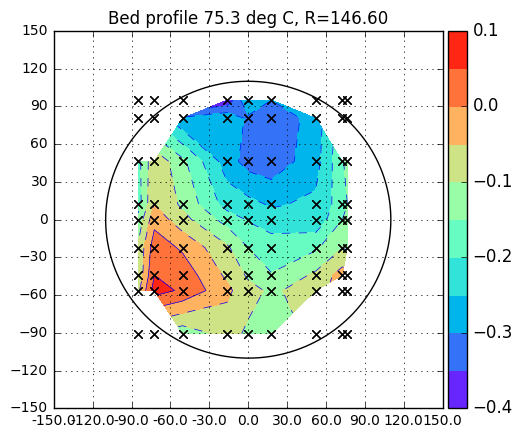

In [439]:
##
def plotBed(filename,zProbeTrigger,shimThickness):
    validlines = []
    tdone = False
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line = line.strip()
            lstl = line.split(' ')
            # only use lines with Bed X: in them for dataframe
            if 'Bed X:' in line:
                # remove unwanted clutter, keep only x,y,z
                validlines.append([float(lstl[i]) for i in [4,6,8]])
            # if temperature lines, get values
            if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                print('Time {} '.format(lstl[0]))
                bedtemp = lstl[5].split(':')[1]
                print('Bed temperature is {} deg C'.format(bedtemp))
                print('Nozzle temperature is {} deg C'.format(lstl[3].split(':')[1]))
                tdone = True
            if 'M665' in line:
                drad = lstl[6][1:]

                
# 22:50:02.719 : echo:  M665 L278.00 R147.50 S100.00 A0.00 B0.00 C0.00
           

    # make pandas dataframe
    df = pd.DataFrame(validlines,columns=['x','y','z'])
    # the g30 command already corrected for the x,y offset
    # correct for probe offset and friction shim to get to metal
    df['x'] = df['x'] 
    df['y'] = df['y'] 
    df['z'] = df['z'] - (zProbeTrigger - shimThickness)
    
    dfr = df.groupby(by=['x','y']).aggregate(np.mean).reset_index().sort_values(by=['x','y'])
#     print(dfr)
#     print(dfr.columns)
#     print(np.max(dfr['z'])-np.min(dfr['z']))
    
    xUni = np.sort(dfr['x'].unique())
    yUni = np.sort(dfr['y'].unique())
    xUm,yUm = np.meshgrid(xUni,yUni)

    dfp = dfr.pivot(index='y', columns='x', values='z')
    print(dfp)
    
    p = ryplot.Plotter(1,1,2,figsize=(12,5));
    # q = ryplot.Plotter(2,figsize=(15,15));
    p.meshContour(1,xUm,yUm,dfp,contLabel=False,cbarshow=True,drawGrid=True,
                  levels=10,pltaxis=[-150,150,-150,150],
                  ptitle='Bed profile {} deg C, R={}'.format(bedtemp,drad));

    p.plot(1,xb,yb,plotCol=['k']);
    p.plot(1,xUm,yUm,plotCol=['k'],markers=['x'],linestyle='');

plotBed('20170312b-bed-63pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 22:47:09.011 
Bed temperature is 75.5 deg C
Nozzle temperature is 28.5 deg C
[-84.83 -50.61 -16.39  17.83  52.06  76.5 ] [-90.56 -56.33 -22.11  12.11  46.33  80.56]
x       -84.83  -50.61  -16.39   17.83   52.06   76.50
y                                                     
-90.56     NaN   0.024   0.192     NaN     NaN     NaN
-56.33   0.306   0.514   0.492   0.402   0.288     NaN
-22.11   0.410   0.606   0.618   0.464   0.318   0.264
 12.11   0.390   0.586   0.536   0.424   0.284   0.204
 46.33   0.276   0.466   0.362   0.250   0.170   0.132
 80.56     NaN   0.128   0.206   0.080   0.000     NaN


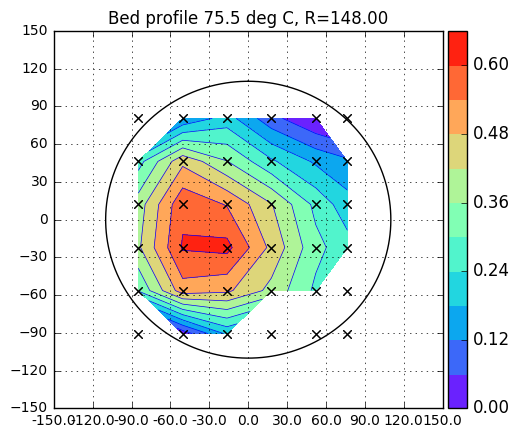

In [332]:
plotBed('20170311d-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 22:54:32.367 
Bed temperature is 74.8 deg C
Nozzle temperature is 29.3 deg C


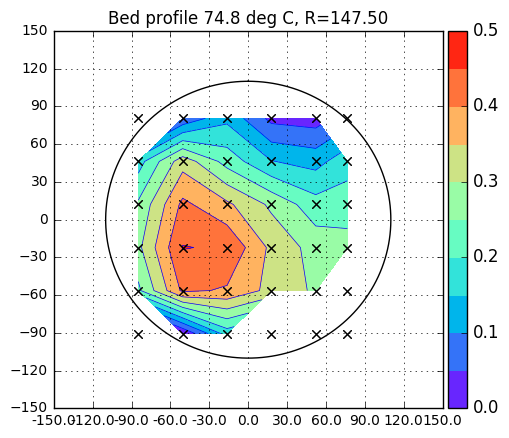

In [320]:
plotBed('20170311e-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 23:03:31.135 
Bed temperature is 75.3 deg C
Nozzle temperature is 29.2 deg C


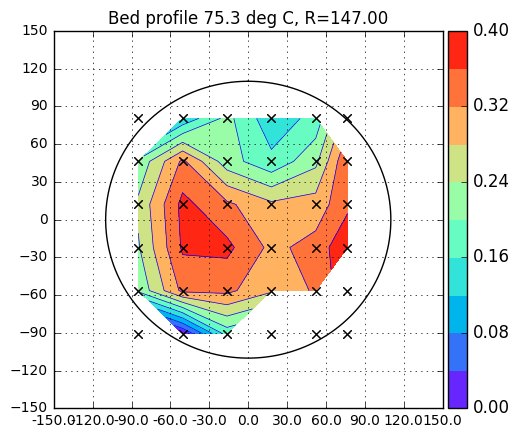

In [321]:
plotBed('20170311f-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 23:09:21.209 
Bed temperature is 74.4 deg C
Nozzle temperature is 29.6 deg C


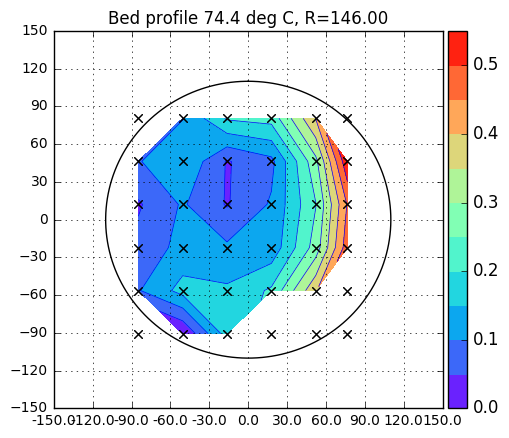

In [322]:
plotBed('20170311g-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 23:15:14.253 
Bed temperature is 75.4 deg C
Nozzle temperature is 29.7 deg C


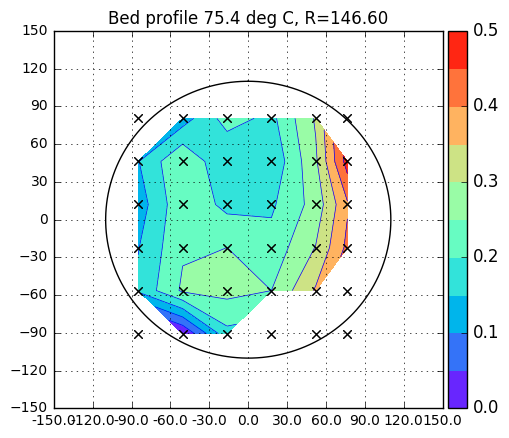

In [323]:
plotBed('20170311h-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 23:30:08.772 
Bed temperature is 31.9 deg C
Nozzle temperature is 24.9 deg C


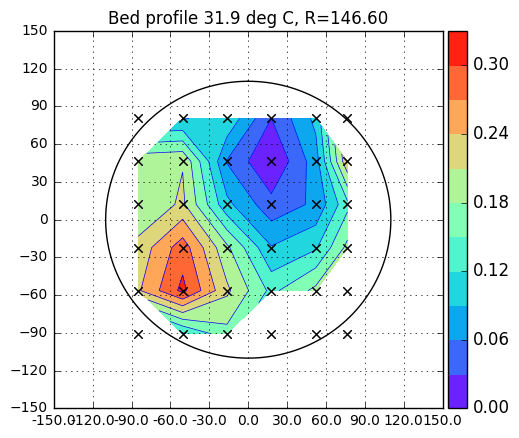

In [325]:
plotBed('20170311i-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)


Time 23:30:08.772 
Bed temperature is 31.9 deg C
Nozzle temperature is 24.9 deg C


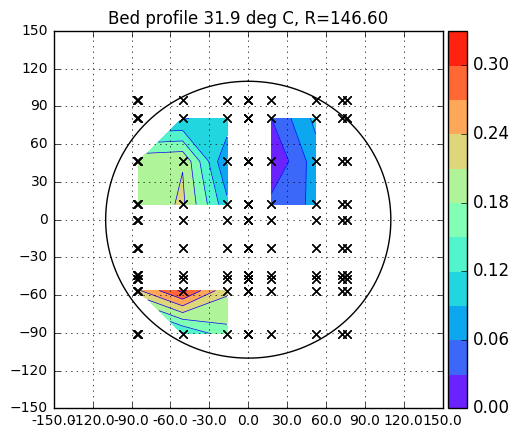

In [327]:
plotBed('20170312a-bed-29pos.txt',zProbeTrigger=0.7,shimThickness=0.1)
